In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
import copy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
from temperature_scaling import ModelWithTemperature, _ECELoss
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score

In [2]:
zero_noise = pd.read_csv("data/zero_noise.csv")
low_noise = pd.read_csv("data/low_noise.csv")
high_noise = pd.read_csv("data/high_noise.csv")
low_noise.drop(columns=["data_type"], inplace=True)
high_noise.drop(columns=["data_type"], inplace=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def encode(v, class_values):
    return class_values.index(v)

def encode_target(v, class_values):
    return class_values.index(v)

class_values_zero = list(zero_noise.era.unique())
class_values_zero_target_5 = list(zero_noise.target_5_val.unique())
class_values_zero_target_10 = list(zero_noise.target_10_val.unique())
zero_noise["era_label"] = zero_noise["era"].apply(encode, args=(class_values_zero,))
zero_noise["target_5_val_label"] = zero_noise["target_5_val"].apply(encode_target, args=(class_values_zero_target_5,))
zero_noise["target_10_val_label"] = zero_noise["target_10_val"].apply(encode_target, args=(class_values_zero_target_10,))

class_values_low = list(low_noise.era.unique())
class_values_low_target_5 = list(low_noise.target_5_val.unique())
class_values_low_target_10 = list(low_noise.target_10_val.unique())
low_noise["era_label"] = low_noise["era"].apply(encode, args=(class_values_low,))
low_noise["target_5_val_label"] = low_noise["target_5_val"].apply(encode_target, args=(class_values_low_target_5,))
low_noise["target_10_val_label"] = low_noise["target_10_val"].apply(encode_target, args=(class_values_low_target_10,))

class_values_high = list(high_noise.era.unique())
class_values_high_target_5 = list(high_noise.target_5_val.unique())
class_values_high_target_10 = list(high_noise.target_10_val.unique())
high_noise["era_label"] = high_noise["era"].apply(encode, args=(class_values_high,))
high_noise["target_5_val_label"] = high_noise["target_5_val"].apply(encode_target, args=(class_values_high_target_5,))
high_noise["target_10_val_label"] = high_noise["target_10_val"].apply(encode_target, args=(class_values_high_target_10,))

dataset = high_noise
target_column = "target_10_val_label"
output_classes = 12 if target_column=="era_label" else 5

In [4]:
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return (
            torch.tensor(self.X[index], dtype=torch.float32, device=device),
            torch.tensor(self.y[index], dtype=torch.long, device=device),
        )

In [5]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))

dataset = dataset.sample(frac=1).reset_index(drop=True)
train_dataset = dataset.iloc[:train_size]
val_dataset = dataset.iloc[train_size:train_size+val_size]
test_dataset = dataset.iloc[train_size+val_size:]

train_X = train_dataset.iloc[:, :-8].values
train_y = train_dataset.loc[:, target_column].values

val_X = val_dataset.iloc[:, :-8].values
val_y = val_dataset.loc[:, target_column].values

test_X = test_dataset.iloc[:, :-8].values
test_y = test_dataset.loc[:, target_column].values

In [6]:
train_dataset = CustomDataset(train_X, train_y)
val_dataset = CustomDataset(val_X, val_y)
test_dataset = CustomDataset(test_X, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
class MLP(nn.Module):
    def __init__(self, layers, autoencoder):
        super().__init__()
        self.layers = layers
        self.autoencoder = autoencoder
        self.linear = nn.Linear(output_classes, 1)

    def forward(self, x):
        features = x.to(device)
        subsets_list = [features[:, :16], features[:, 8:24]]
        x = self.autoencoder.aggregate(subsets_list)

        for layer in self.layers[:-1]:
            x = layer(x)

        logits = self.layers[-1](x).to(torch.float64)
        x1 = self.linear(x)
        tau = torch.sigmoid(x1).to(torch.float64)

        return logits, tau
    

class Autoencoder(nn.Module):
    def __init__(self, input_dim=24, encoding_dim=16):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 48),
            nn.ReLU(),
            nn.Linear(48, 32),
            nn.ReLU(),
            nn.Linear(32, encoding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 48),
            nn.ReLU(),
            nn.Linear(48, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x_recon = self.decoder(x)
        return x, x_recon

    
class NoiseAttentionLoss(nn.Module):
    def __init__(self, lambda_=1.0):
        super(NoiseAttentionLoss, self).__init__()
        self.lambda_ = lambda_

    def forward(self, logits, y, tau):
        y = F.one_hot(y, output_classes).to(torch.float64).to(device)
        perceptual = tau.squeeze(1) * (logits.t() - y.t()) + y.t()
        attention_term = torch.matmul(y, torch.log(perceptual + 1e-8))
        attention_term = attention_term.diag()
        boost_term = torch.log(tau + 1e-8) * self.lambda_

        attention_term = -torch.mean(attention_term)
        boost_term = -torch.mean(boost_term)

        return attention_term + boost_term


class SubTabLoss(nn.Module):
    def __init__(self, alpha=1, beta=1):
        super(SubTabLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, z1, z2, x_recon, x):

        recon_loss = F.mse_loss(x_recon, x)
        distance_loss = torch.mean(torch.norm(z1 - z2, dim=1))

        loss = self.alpha * recon_loss + self.beta * distance_loss
        return loss
    

class SubTab(nn.Module):
    def __init__(self, input_dim=16, encoding_dim=20, num_subsets=3):
        super(SubTab, self).__init__()
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.num_subsets = num_subsets
        self.feature_1_end = 16
        self.feature_2_end = 24
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, self.encoding_dim))
        
        self.decoder = nn.Sequential(
            nn.Linear(self.encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, self.input_dim))
        
    def forward(self, subset):
        x = self.encoder(subset)
        x = self.decoder(x)
        return x        
    
    def aggregate(self, subsets):
        z = []
        for subset in subsets:
            z.append(self.encoder(subset).unsqueeze(0))
        z = torch.cat(z, dim=0)
        mean = torch.mean(z, dim=0)

        return mean

layers = nn.ModuleList([
        nn.Linear(20, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32, output_classes),
        nn.Softmax(dim=1),
    ])

In [8]:
autoencoder = SubTab(input_dim=16, encoding_dim=20, num_subsets=2).to(device)
model = MLP(layers, autoencoder).to(device)

learning_rate = 0.0025
learning_rate_auto = 0.001
weight_decay = 0.0001
epochs = 5
epochs_auto = 5

# criterion = nn.CrossEntropyLoss().to(device)
criterion = NoiseAttentionLoss(lambda_=50)
criterion_auto = SubTabLoss(alpha=1, beta=0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_auto = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate_auto)

In [9]:
def train_autoencoder(model, dataloader, epochs, criterion, optimizer):
    model.train()
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0

        for features, _ in iter(dataloader):
            input = features.to(device)
            target = features.to(device)
            optimizer.zero_grad()
            outputs = model(input)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Training loss: {running_loss/len(dataloader)}")

# train_autoencoder(autoencoder, train_dataloader, epochs_auto, criterion_auto, optimizer_auto)

In [10]:
def train_subtab(model, dataloader, epochs, criterion, optimizer):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for features, _ in dataloader:
            sampled_features = []
            sampled_features.append(features[:, :16])
            sampled_features.append(features[:, 8:24])
            for subset in sampled_features:
                subset = subset.to(device)
                # print(subset.shape)
                optimizer.zero_grad()

                sub_recon = model(subset)
            
            # pos_idx = torch.randint(0, len(features), size=(len(features),))
            # z2 = model(features[pos_idx])[0]
                loss = F.mse_loss(sub_recon, subset)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Training loss: {running_loss/len(dataloader)}")

train_subtab(autoencoder, train_dataloader, 5, criterion_auto, optimizer_auto)
for parameter in autoencoder.parameters():
    parameter.requires_grad = False

Epoch 1/5 - Training loss: 0.011461178156653117
Epoch 2/5 - Training loss: 2.890482710253486e-05
Epoch 3/5 - Training loss: 2.45635987514145e-05
Epoch 4/5 - Training loss: 2.25269199464053e-05
Epoch 5/5 - Training loss: 2.1468728210878478e-05


In [11]:
def train(model, optimizer, loss_fn, epochs, train_dataloader, val_dataloader,
          bagging_mode=False, validation_mode=True, NAL_loss=False, debug_mode=False):
    
    batch=0
    val_losses=[]
    val_accuracies=[]
    train_losses=[]
    train_accuracies=[]
    probs_list = []
    logits_list = []
    labels_list = []
    num_batches=int(len(train_dataloader)*0.9)
    if NAL_loss:
        loss_fn = NoiseAttentionLoss(lambda_=50).to(device)
    else:
        loss_fn = nn.CrossEntropyLoss().to(device)
    for epoch in range(epochs):
        
        train_accuracy=0.0
        train_loss=0.0
        model.train()
        batch=0        
        
        for feature, label in iter(train_dataloader):
            optimizer.zero_grad()
            feature = feature.to(device)
            label = label.to(device)
            
            if NAL_loss:
                output, tau = model(feature)
                loss = loss_fn(output, label, tau)
            else:
                output, tau = model(feature)
                loss = loss_fn(output, label)

            if epoch==epochs-1:
                logits_list.append(output.detach().cpu().numpy())
                probs = torch.softmax(output, dim=1)
                # probs_list.append(probs)
                probs_list.append(probs.detach().cpu().numpy())
                labels_list.append(label.detach().cpu().numpy())
            loss.backward()
            optimizer.step()
            
            train_loss+=(loss.item())/len(label)
            train_accuracy+=torch.sum(torch.argmax(output, dim=1) == label)/len(label)

            batch+=1
            if bagging_mode:
                if batch==num_batches:
                    break
            if debug_mode:
                break
            
        train_losses.append(train_loss/len(train_dataloader))
        train_accuracies.append(train_accuracy/len(train_dataloader))
        print(f"Epoch {epoch+1}/{epochs}")
        print("-----------")
        print(f"Training loss: {train_loss}")
        print(f"Training accuracy: {train_accuracy/len(train_dataloader)}")
        print("-----------------------------------------------")
        
        if validation_mode:
            val_loss, val_acc = validation(model, val_dataloader, loss_fn, NAL_loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
        batch=0

    # if validation_mode:
    #     return train_losses, train_accuracies, val_losses, val_accuracies
    # else:
    #     return train_losses, train_accuracies
    
    return probs_list, logits_list, labels_list
    

def validation(model, val_dataloader, criterion, NAL_loss=False):
    model.eval()
    val_accuracy = 0
    val_loss = 0
    with torch.no_grad():
        for feature, label in iter(val_dataloader):
            feature = feature.to(device)
            label = label.to(device)
            output, tau = model(feature)
            if NAL_loss:
                val_loss += criterion(output, label, tau).item()
            else:
                val_loss += criterion(output, label).item()
            val_accuracy += torch.sum(torch.argmax(output, dim=1) == label)/len(label)
            
        print(f"Validation loss: {val_loss/len(val_dataloader)}")
        print(f"Validation accuracy: {val_accuracy/len(val_dataloader)}")
        print()

    return val_loss/len(val_dataloader), val_accuracy/len(val_dataloader)

def test(model, test_dataloader):
    model.eval()
    probs_list = []
    preds_list = []
    labels_list = []
    logits_list = []

    with torch.no_grad():
        accuracy = 0
        for feature, label in iter(test_dataloader):
            feature, label = feature.to(device), label.to(device)
            outputs, _ = model(feature)
            logits_list.append(outputs.detach().cpu().numpy())
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            probs_list.append(probs.detach().cpu().numpy())
            preds_list.append(preds.detach().cpu().numpy())
            labels_list.append(label.detach().cpu().numpy())
            accuracy += torch.sum(torch.argmax(outputs, dim=1) == label)/len(label)
        print(f"Test accuracy: {accuracy/len(test_dataloader)}")

    return probs_list, preds_list, labels_list, logits_list

def plot(train, val, mode):
    if mode == "accuracy":
        for i in range(len(train)):
            train[i] = train[i].cpu().numpy()
    
    plt.figure(figsize=(10, 5))
    plt.plot(train, label=f"Training {mode}")
    plt.plot(val, label=f"Validation {mode}")
    plt.title(f"Training and Validation {mode} Curve")

    plt.xlabel("Epochs")
    plt.ylabel(f"{mode}")
    plt.legend()
    plt.show()

In [12]:
# criterion = NoiseAttentionLoss(lambda_=50).to(device)
# bagging_models, train_losses, train_accuracies, val_losses, val_accuracies = bagging_train(criterion, 15, train_dataloader, val_dataloader)

In [13]:
def train_single_model(model, optimizer, loss_fn, epochs, train_dataloader, val_dataloader, NAL_loss=False):
    train_losses, train_accuracies, val_losses, val_accuracies = train(
        model, optimizer, loss_fn, epochs, train_dataloader, val_dataloader, validation_mode=True, NAL_loss=NAL_loss
    )

    model.eval()
    misclassified_indices = []
    with torch.no_grad():
        for feature, label in iter(val_dataloader):
            feature = feature.to(device)
            label = label.to(device)
            output, _ = model(feature)
            predictions = torch.argmax(output, dim=1)
            misclassified_indices.extend(
                idx.item() for idx, pred, true_label in zip(torch.where(predictions != label)[0], predictions, label)
                if pred.item() != true_label.item()
            )

    misclassified_X = val_X[misclassified_indices]
    misclassified_y = val_y[misclassified_indices]

    return model, misclassified_X, misclassified_y, train_losses, train_accuracies, val_losses, val_accuracies

def cascaded_train(loss_fn, epochs, train_dataloader, val_dataloader):
    models = []
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    model = MLP(layers, autoencoder).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=0.0001)
    model, misclassified_X, misclassified_y, train_loss, train_acc, val_loss, val_acc = train_single_model(
        model, optimizer, loss_fn, epochs, train_dataloader, val_dataloader, NAL_loss=True
    )
    models.append(model)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    for i in range(2):
        if not misclassified_X.any():
            break

        misclassified_dataset = CustomDataset(misclassified_X, misclassified_y)
        misclassified_dataloader = DataLoader(misclassified_dataset, batch_size=64, shuffle=True)

        model = MLP(layers, autoencoder).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=0.0001)
        model, misclassified_X, misclassified_y, train_loss, train_acc, val_loss, val_acc = train_single_model(
            model, optimizer, loss_fn, epochs, misclassified_dataloader, val_dataloader, NAL_loss=True
        )
        models.append(model)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    return models, train_losses, train_accuracies, val_losses, val_accuracies

In [14]:
# models, train_losses, train_accuracies, val_losses, val_accuracies = cascaded_train(criterion, 15, train_dataloader, val_dataloader)

In [15]:
# class MLP(nn.Module):
#     def __init__(self, layers, autoencoder):
#         super().__init__()
#         self.layers = layers
#         self.autoencoder = autoencoder
#         self.linear = nn.Linear(output_classes, 1)

#     def forward(self, x):
#         for layer in self.layers[:-1]:
#             x = layer(x)
#         logits = self.layers[-1](x).to(torch.float64).to(device)
#         x1 = self.linear(x)
#         tau = torch.sigmoid(x1).to(torch.float64).to(device)
#         return logits, tau

class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, X):
        logits, _ = self.model(X)
        return logits

def temperature_scale(model, val_dataloader):
    model.eval()
    wrapped_model = WrappedModel(model)
    model_with_temperature = ModelWithTemperature(wrapped_model)
    model_with_temperature = model_with_temperature.set_temperature(val_dataloader)
    return model_with_temperature

def plot_calibration(model, val_dataloader):
    model.eval()
    probs_list = []
    labels_list = []
    with torch.no_grad():
        for feature, label in iter(val_dataloader):
            feature = feature.to(device)
            label = label.to(device)
            logits, _ = model(feature)
            probs = torch.softmax(logits, dim=1)
            probs_list.append(probs)
            labels_list.append(label)

    probs = torch.cat(probs_list).cpu().numpy()
    labels = torch.cat(labels_list).cpu().numpy()

    for c in range(output_classes):
        y_true = np.array([1 if l == c else 0 for l in labels])
        y_prob = probs[:, c]
        CalibrationDisplay.from_predictions(y_true, y_prob, n_bins=10, fraction_positive=y_true.mean())
        plt.show()

def calculate_ece(model, dataloader):
    ece_criterion = _ECELoss()
    model.eval()
    logits_list = []
    labels_list = []
    with torch.no_grad():
        for feature, label in iter(dataloader):
            feature = feature.to(device)
            label = label.to(device)
            logits = model(feature)
            logits_list.append(logits)
            labels_list.append(label)

    logits = torch.cat(logits_list)
    labels = torch.cat(labels_list)

    ece = ece_criterion(logits, labels).item()
    return ece

def cascade_models(models, val_dataloader, threshold=0.7):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for feature, label in iter(val_dataloader):
            feature = feature.to(device)
            label = label.to(device)
            preds = []
            confidences = []
            for model in models:
                model.eval()
                logits, _ = model(feature)
                probs = torch.softmax(logits, dim=1)
                confidence, pred = probs.max(dim=1)
                preds.append(pred)
                confidences.append(confidence)
                if torch.mean(confidence) >= threshold:
                    break
            all_preds.extend(preds[-1])
            all_labels.extend(label)

    all_preds = torch.stack(all_preds)
    all_labels = torch.stack(all_labels)
    accuracy = torch.sum(all_preds == all_labels) / len(all_labels)
    print(f"Cascaded models accuracy: {accuracy:.4f}")

In [16]:
def calculate_ece(model, dataloader):
    ece_criterion = _ECELoss()
    model.eval()
    logits_list = []
    labels_list = []
    with torch.no_grad():
        for feature, label in iter(dataloader):
            feature = feature.to(device)
            label = label.to(device)
            logits = model(feature)
            logits_list.append(logits)
            labels_list.append(label)

    logits = torch.cat(logits_list)
    labels = torch.cat(labels_list)

    ece = ece_criterion(logits, labels).item()
    return ece

def train_cascade(models, optimizers, train_dataset, val_dataset, threshold=0.5, NAL_Loss=False, epochs=10):
    train_set = copy.deepcopy(train_dataset)

    for i, model in enumerate(models):
        low_confidence_data = []
        low_confidence_labels = []
        print(f"Training model {i+1}...")
        print(f"Size of train_dataset: {len(train_set)}")
        print()
        train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
        probs_list, logits_list, labels_list = train(model, optimizers[i], criterion, epochs, train_dataloader, val_dataloader, NAL_loss=NAL_Loss)

        model_with_temperature = ModelWithTemperature(model)
        model_with_temperature = model_with_temperature.set_temperature(val_dataloader)

        probs = np.concatenate(probs_list, axis=0)
        gini = 1 - np.sum(probs ** 2, axis=1)

        low_confidence_idx = gini >= threshold
        low_confidence_indices = np.where(low_confidence_idx)[0]

        if i < len(models) - 1:
            low_confidence_data.extend([train_set.X[j] for j in low_confidence_indices])
            low_confidence_labels.extend([train_set.y[j] for j in low_confidence_indices])

            new_dataset = CustomDataset(low_confidence_data, low_confidence_labels)

            del train_set
            train_set = copy.deepcopy(new_dataset)

        # print(f"Low-confidence data size: {len(low_confidence_data)}")

        ece = calculate_ece(model_with_temperature, val_dataloader)
        
        print(f"Model {i+1} ECE: {ece:.4f}")
        print("##############################################")

    return models, probs_list, logits_list, labels_list

In [17]:
model4 = MLP(layers, autoencoder).to(device)
model5 = MLP(layers, autoencoder).to(device)
model6 = MLP(layers, autoencoder).to(device)
optimizer1 = torch.optim.Adam(model4.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer2 = torch.optim.Adam(model5.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer3 = torch.optim.Adam(model6.parameters(), lr=learning_rate, weight_decay=weight_decay)
models = [model4, model5, model6]
optimizers = [optimizer1, optimizer2, optimizer3]
epochs = 10
threshold = 0.75

models, probs_list, logits_list, labels_list = train_cascade(models, optimizers, train_dataset, val_dataset, threshold=threshold, NAL_Loss=True, epochs=epochs)

Training model 1...
Size of train_dataset: 199680

Epoch 1/10
-----------
Training loss: 67.32199334842684
Training accuracy: 0.5001201629638672
-----------------------------------------------
Validation loss: 1.1287332850427734
Validation accuracy: 0.5589342713356018

Epoch 2/10
-----------
Training loss: 52.005424298213605
Training accuracy: 0.5768880248069763
-----------------------------------------------
Validation loss: 1.0281743660809617
Validation accuracy: 0.5856170058250427

Epoch 3/10
-----------
Training loss: 47.451126332714594
Training accuracy: 0.6021333932876587
-----------------------------------------------
Validation loss: 0.943528547181872
Validation accuracy: 0.6054086685180664

Epoch 4/10
-----------
Training loss: 45.236807060599844
Training accuracy: 0.6124599575996399
-----------------------------------------------
Validation loss: 0.9148150865412766
Validation accuracy: 0.620312511920929

Epoch 5/10
-----------
Training loss: 44.50334419355021
Training accurac

In [18]:
def test_cascade(models, test_set, threshold=0.5):
    all_preds = []
    all_labels = []
    all_probs = []
    all_logits = []
    high_confidence_data = []
    high_confidence_labels = []
    abstains=[]
    abstain_labels=[]
    
    with torch.no_grad():
        for i, model in enumerate(models):
            low_confidence_data = []
            low_confidence_labels = []
            test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)
            
            probs_list, preds_list, labels_list, logits_list = test(model, test_dataloader)
            probs = np.concatenate(probs_list, axis=0)
            preds = np.concatenate(preds_list, axis=0)
            labels = np.concatenate(labels_list, axis=0)
            logits = np.concatenate(logits_list, axis=0)

            gini = 1 - np.sum(probs ** 2, axis=1)
            
            low_confidence_idx = gini >= threshold
            low_confidence_indices = np.where(low_confidence_idx)[0]

            high_confidence_idx = gini < threshold
            high_confidence_indices = np.where(high_confidence_idx)[0]

            high_confidence_preds = preds[high_confidence_idx]
            high_confidence_labels = labels[high_confidence_indices]

            all_preds.extend(high_confidence_preds)
            all_labels.extend(high_confidence_labels)
            all_probs.extend(probs[high_confidence_idx])
            all_logits.extend(logits[high_confidence_idx])

            low_confidence_data.extend([test_set.X[j] for j in low_confidence_indices])
            low_confidence_labels.extend([test_set.y[j] for j in low_confidence_indices])
            
            if i != len(models) - 1:
                new_dataset = CustomDataset(low_confidence_data, low_confidence_labels)
                del test_set
                test_set = copy.deepcopy(new_dataset)
            else:
                abstain_preds = preds[low_confidence_idx]
                abstain_label = labels[low_confidence_indices]

                abstains.extend(abstain_preds)
                abstain_labels.extend(abstain_label)

    return all_preds, all_labels, all_probs, all_logits, high_confidence_data, high_confidence_labels, abstains, abstain_labels


In [19]:
all_preds, all_labels, all_probs, all_logits, high_confidence_data, high_confidence_labels, abstains, abstain_labels = test_cascade(models, test_dataset, threshold=threshold)

Test accuracy: 0.6289262771606445
Test accuracy: 0.6272949576377869
Test accuracy: 0.6276819109916687


In [20]:
print(accuracy_score(all_labels, all_preds))

0.9987225888865233


In [21]:
print(len(all_preds),len(abstains))

9394 15566


In [22]:
len(all_probs)

9394

In [23]:
len(all_labels)

9394

In [24]:
labels_list[0][0]

1

In [25]:
def binarize(target, c):
    return np.array([1 if t==c else 0 for t in target])

def plot_calibration(models, test_set, threshold=0.75):
    all_preds, all_labels, all_probs, all_logits, high_confidence_data, high_confidence_labels, abstains, abstain_labels = test_cascade(models, test_set, threshold=threshold)

    binarize_classes_after = [binarize(all_labels, c) for c in range(5)]
    
    for c in range(5):
        y_true = binarize_classes_after[c]
        y_prob = np.array(all_probs)[:, c]
        true_positive_rate, predicted_prob = calibration_curve(y_true, y_prob, n_bins=10)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(predicted_prob, true_positive_rate, marker='.')
        plt.title(f"After Calibration plot for class {c}")
        plt.xlabel("Predicted probability")
        plt.ylabel("True positive rate")
        plt.show()    
    

Test accuracy: 0.6289262771606445
Test accuracy: 0.6276772618293762
Test accuracy: 0.6273928880691528


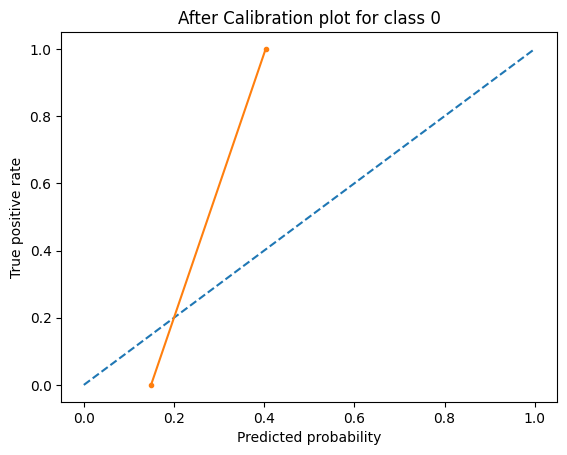

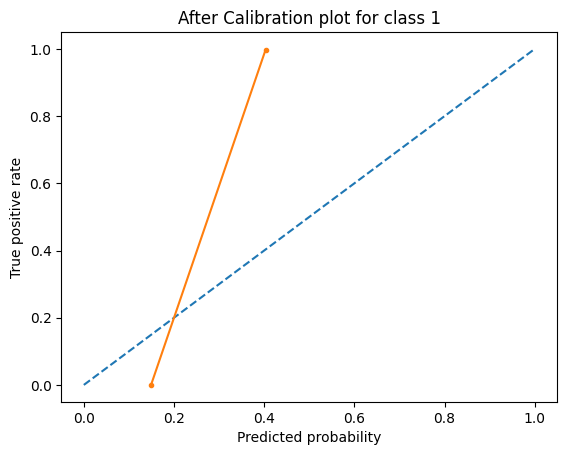

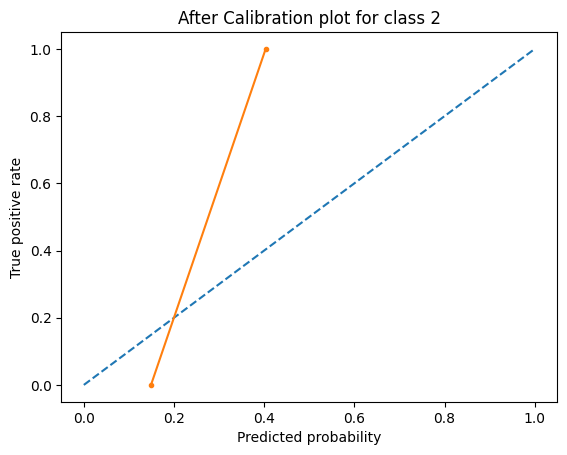

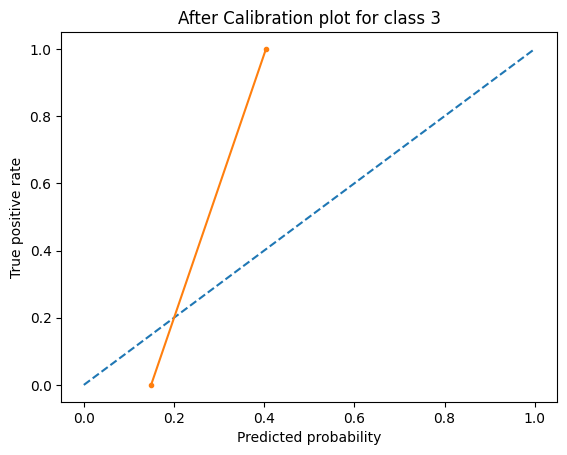

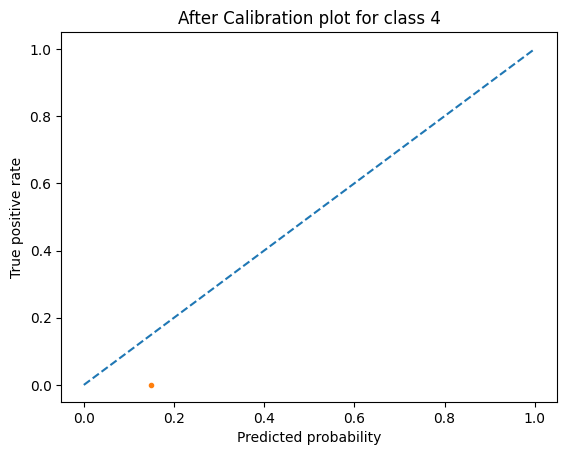

In [26]:
plot_calibration(models, test_dataset, threshold=threshold)

# HIGH NOISE Target 5

In [27]:
dataset = high_noise
target_column = "target_5_val_label"
output_classes = 12 if target_column=="era_label" else 5

In [28]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))

dataset = dataset.sample(frac=1).reset_index(drop=True)
train_dataset = dataset.iloc[:train_size]
val_dataset = dataset.iloc[train_size:train_size+val_size]
test_dataset = dataset.iloc[train_size+val_size:]

train_X = train_dataset.iloc[:, :-8].values
train_y = train_dataset.loc[:, target_column].values

val_X = val_dataset.iloc[:, :-8].values
val_y = val_dataset.loc[:, target_column].values

test_X = test_dataset.iloc[:, :-8].values
test_y = test_dataset.loc[:, target_column].values

In [29]:
train_dataset = CustomDataset(train_X, train_y)
val_dataset = CustomDataset(val_X, val_y)
test_dataset = CustomDataset(test_X, test_y)

In [30]:
model1 = MLP(layers, autoencoder).to(device)
model2 = MLP(layers, autoencoder).to(device)
model3 = MLP(layers, autoencoder).to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate, weight_decay=weight_decay)
models = [model1, model2, model3]
optimizers = [optimizer1, optimizer2, optimizer3]
epochs = 10
threshold = 0.75

models, probs_list, logits_list, labels_list = train_cascade(models, optimizers, train_dataset, val_dataset, threshold=threshold, NAL_Loss=True, epochs=epochs)

Training model 1...
Size of train_dataset: 199680

Epoch 1/10
-----------
Training loss: 61.487206205256925
Training accuracy: 0.5438200831413269
-----------------------------------------------
Validation loss: 1.1083382429287862
Validation accuracy: 0.5723156929016113

Epoch 2/10
-----------
Training loss: 54.221498767554024
Training accuracy: 0.5742588043212891
-----------------------------------------------
Validation loss: 1.1009709335701556
Validation accuracy: 0.575080156326294

Epoch 3/10
-----------
Training loss: 47.85162924211737
Training accuracy: 0.5876252055168152
-----------------------------------------------
Validation loss: 0.9499369021417637
Validation accuracy: 0.5935496687889099

Epoch 4/10
-----------
Training loss: 46.00421257485409
Training accuracy: 0.5932942628860474
-----------------------------------------------
Validation loss: 0.940136557457588
Validation accuracy: 0.5958734154701233

Epoch 5/10
-----------
Training loss: 45.81357979442569
Training accuracy

In [31]:
all_preds, all_labels, all_probs, all_logits, high_confidence_data, high_confidence_labels, abstains, abstain_labels = test_cascade(models, test_dataset, threshold=threshold)

Test accuracy: 0.6015625
Test accuracy: 0.6004655957221985
Test accuracy: 0.6003592014312744


In [32]:
print(accuracy_score(all_labels, all_preds))

0.9986602657139667


In [33]:
print(len(all_preds),len(abstains))

8957 16003


Test accuracy: 0.6015625
Test accuracy: 0.6001865863800049
Test accuracy: 0.6013649106025696


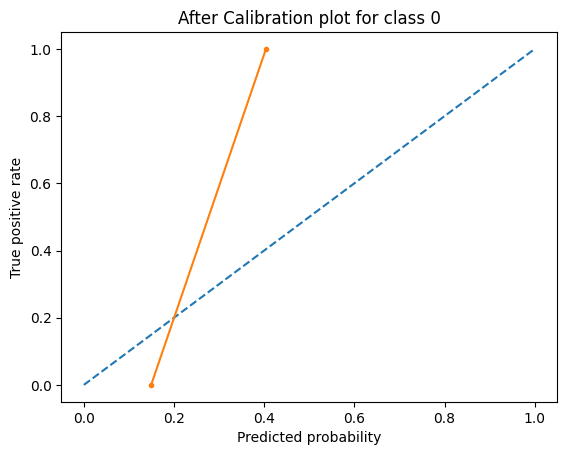

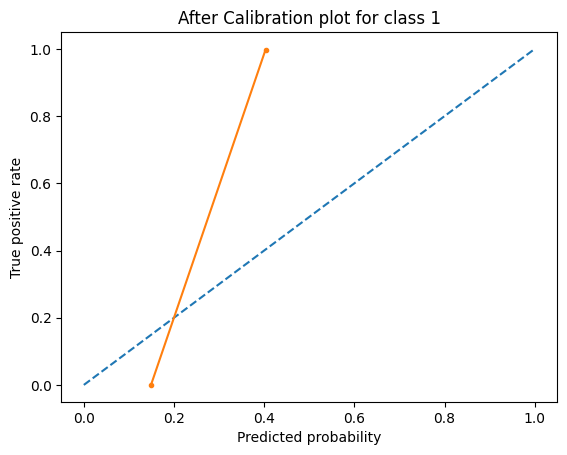

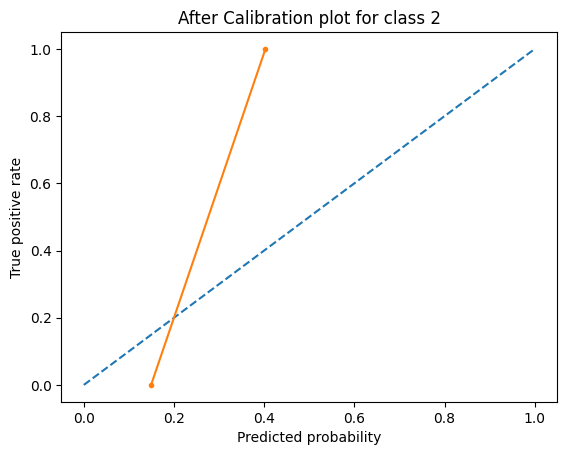

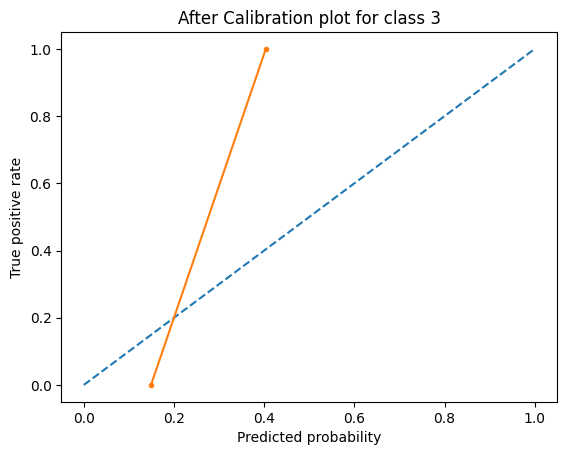

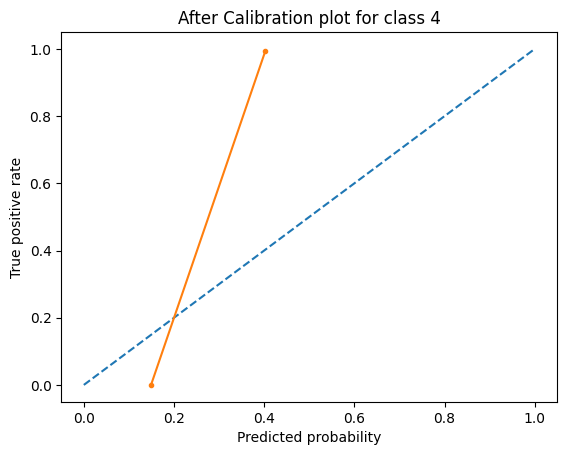

In [34]:
plot_calibration(models, test_dataset, threshold=threshold)

# Low Noise target 10 

In [35]:
dataset = low_noise
target_column = "target_10_val_label"
output_classes = 12 if target_column=="era_label" else 5

In [36]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))

dataset = dataset.sample(frac=1).reset_index(drop=True)
train_dataset = dataset.iloc[:train_size]
val_dataset = dataset.iloc[train_size:train_size+val_size]
test_dataset = dataset.iloc[train_size+val_size:]

train_X = train_dataset.iloc[:, :-8].values
train_y = train_dataset.loc[:, target_column].values

val_X = val_dataset.iloc[:, :-8].values
val_y = val_dataset.loc[:, target_column].values

test_X = test_dataset.iloc[:, :-8].values
test_y = test_dataset.loc[:, target_column].values

In [37]:
train_dataset = CustomDataset(train_X, train_y)
val_dataset = CustomDataset(val_X, val_y)
test_dataset = CustomDataset(test_X, test_y)

In [38]:
model7 = MLP(layers, autoencoder).to(device)
model8 = MLP(layers, autoencoder).to(device)
model9 = MLP(layers, autoencoder).to(device)
optimizer1 = torch.optim.Adam(model7.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer2 = torch.optim.Adam(model8.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer3 = torch.optim.Adam(model9.parameters(), lr=learning_rate, weight_decay=weight_decay)
models = [model7, model8, model9]
optimizers = [optimizer1, optimizer2, optimizer3]
epochs = 10
threshold = 0.75

models, probs_list, logits_list, labels_list = train_cascade(models, optimizers, train_dataset, val_dataset, threshold=threshold, NAL_Loss=True, epochs=epochs)

Training model 1...
Size of train_dataset: 249600

Epoch 1/10
-----------
Training loss: 113.53526810340243
Training accuracy: 0.6294190883636475
-----------------------------------------------
Validation loss: 1.6062438106392036
Validation accuracy: 0.6591636538505554

Epoch 2/10
-----------
Training loss: 97.2953410916079
Training accuracy: 0.6619591116905212
-----------------------------------------------
Validation loss: 1.5617872812594218
Validation accuracy: 0.6681608557701111

Epoch 3/10
-----------
Training loss: 58.33539381371836
Training accuracy: 0.7418429255485535
-----------------------------------------------
Validation loss: 0.5026012849548364
Validation accuracy: 0.8058401346206665

Epoch 4/10
-----------
Training loss: 31.193708977399854
Training accuracy: 0.8004927635192871
-----------------------------------------------
Validation loss: 0.4917549099646155
Validation accuracy: 0.8098744750022888

Epoch 5/10
-----------
Training loss: 30.685193340450674
Training accura

In [39]:
models = [model7, model8, model9]


In [40]:
all_preds, all_labels, all_probs, all_logits, high_confidence_data, high_confidence_labels, abstains, abstain_labels = test_cascade(models, test_dataset, threshold=threshold)

Test accuracy: 0.805712103843689
Test accuracy: 0.8058513402938843
Test accuracy: 0.8065506815910339


In [41]:
print(accuracy_score(all_labels, all_preds))

0.9961443675967883


In [42]:
print(len(all_preds), len(abstains))

25158 6042


Test accuracy: 0.805712103843689
Test accuracy: 0.8017758131027222
Test accuracy: 0.8024255037307739


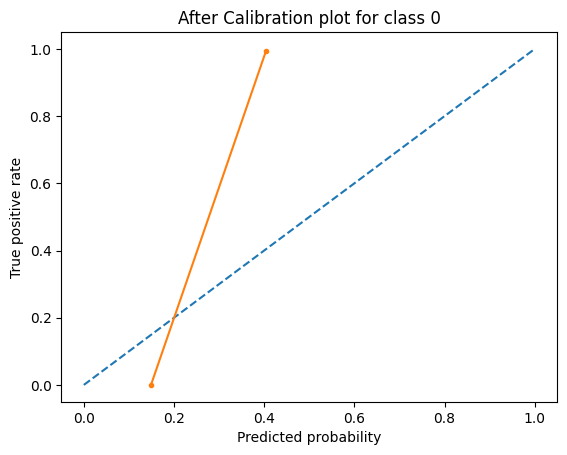

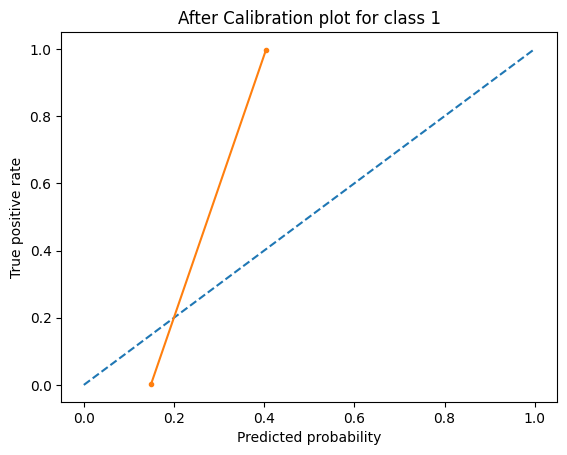

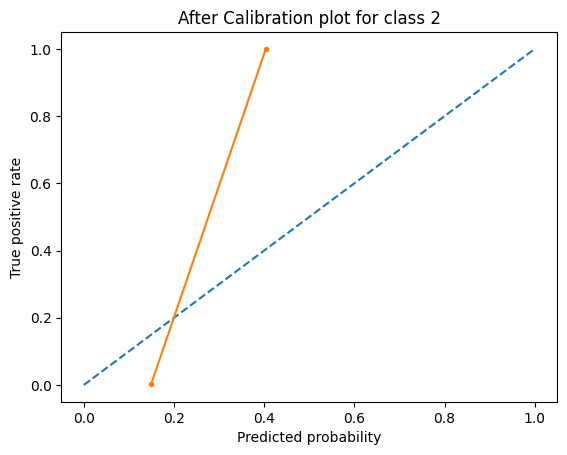

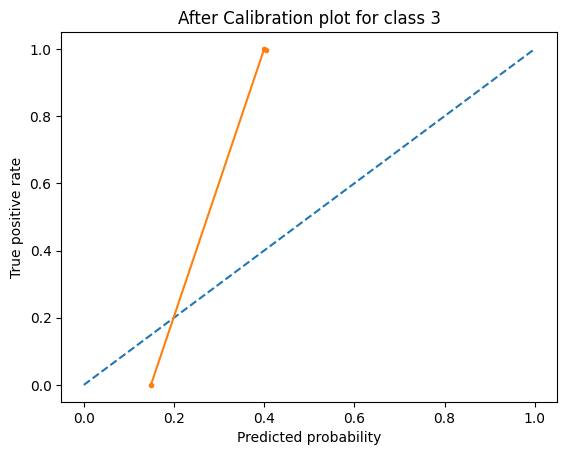

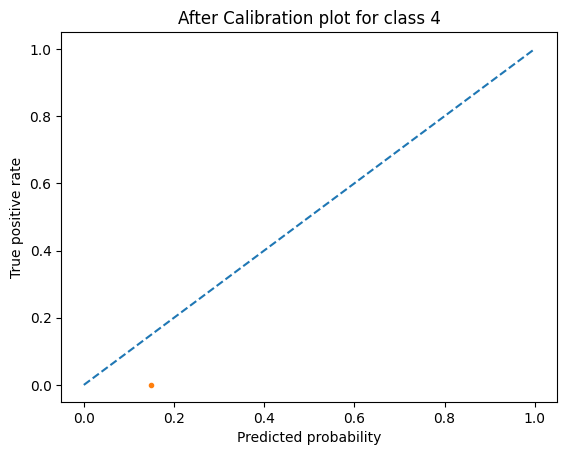

In [43]:
plot_calibration(models, test_dataset, threshold=threshold)

# Low Noise target 5

In [44]:
dataset = low_noise
target_column = "target_5_val_label"
output_classes = 12 if target_column=="era_label" else 5

In [45]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))

dataset = dataset.sample(frac=1).reset_index(drop=True)
train_dataset = dataset.iloc[:train_size]
val_dataset = dataset.iloc[train_size:train_size+val_size]
test_dataset = dataset.iloc[train_size+val_size:]

train_X = train_dataset.iloc[:, :-8].values
train_y = train_dataset.loc[:, target_column].values

val_X = val_dataset.iloc[:, :-8].values
val_y = val_dataset.loc[:, target_column].values

test_X = test_dataset.iloc[:, :-8].values
test_y = test_dataset.loc[:, target_column].values

In [46]:
train_dataset = CustomDataset(train_X, train_y)
val_dataset = CustomDataset(val_X, val_y)
test_dataset = CustomDataset(test_X, test_y)

In [47]:
model10 = MLP(layers, autoencoder).to(device)
model11 = MLP(layers, autoencoder).to(device)
model12 = MLP(layers, autoencoder).to(device)
optimizer1 = torch.optim.Adam(model10.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer2 = torch.optim.Adam(model11.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer3 = torch.optim.Adam(model12.parameters(), lr=learning_rate, weight_decay=weight_decay)
models = [model10, model11, model12]
optimizers = [optimizer1, optimizer2, optimizer3]
epochs = 10
threshold = 0.75

models, probs_list, logits_list, labels_list = train_cascade(models, optimizers, train_dataset, val_dataset, threshold=threshold, NAL_Loss=True, epochs=epochs)

Training model 1...
Size of train_dataset: 249600

Epoch 1/10
-----------
Training loss: 39.57212888281968
Training accuracy: 0.7496113777160645
-----------------------------------------------
Validation loss: 0.581931414169124
Validation accuracy: 0.7670658230781555

Epoch 2/10
-----------
Training loss: 34.787909463690646
Training accuracy: 0.7722916603088379
-----------------------------------------------
Validation loss: 0.5589256554628736
Validation accuracy: 0.7746862173080444

Epoch 3/10
-----------
Training loss: 33.967971172072
Training accuracy: 0.7774719595909119
-----------------------------------------------
Validation loss: 0.5596866334562915
Validation accuracy: 0.7760950326919556

Epoch 4/10
-----------
Training loss: 33.52969923288608
Training accuracy: 0.7796794772148132
-----------------------------------------------
Validation loss: 0.549896750338704
Validation accuracy: 0.7778240442276001

Epoch 5/10
-----------
Training loss: 33.27804316820681
Training accuracy: 0

In [48]:
models = [model10, model11, model12]

In [49]:
all_preds, all_labels, all_probs, all_logits, high_confidence_data, high_confidence_labels, abstains, abstain_labels = test_cascade(models, test_dataset, threshold=threshold)

Test accuracy: 0.7857325673103333
Test accuracy: 0.787558913230896
Test accuracy: 0.7868446111679077


In [50]:
print(accuracy_score(all_labels, all_preds))

0.9977849375755135


In [51]:
print(len(all_preds),len(abstains))

24830 6370


Test accuracy: 0.7857325673103333
Test accuracy: 0.7884424328804016
Test accuracy: 0.7878143787384033


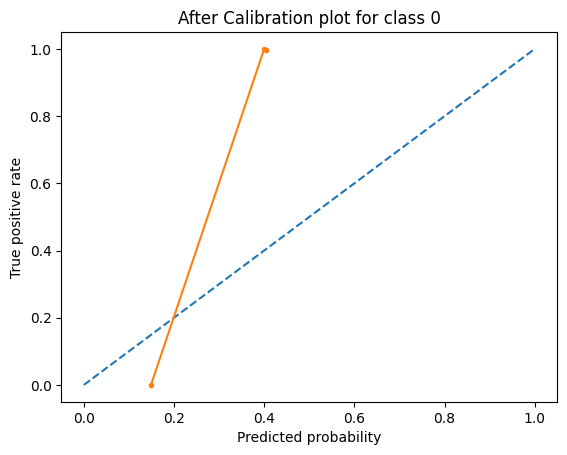

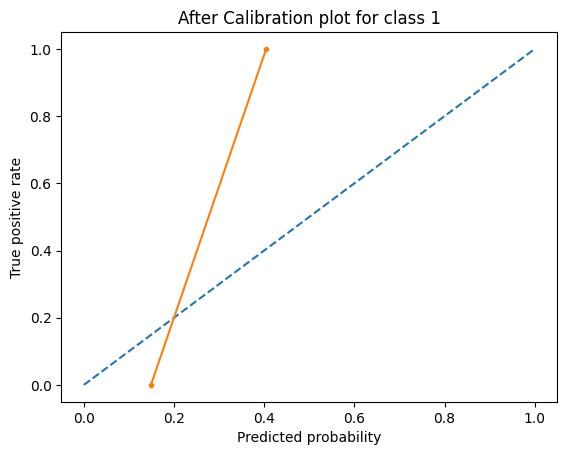

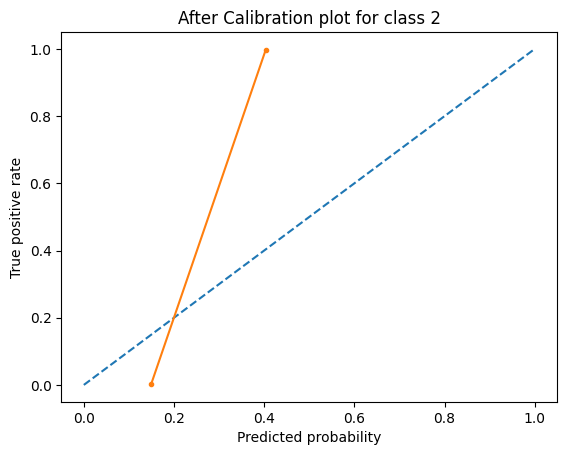

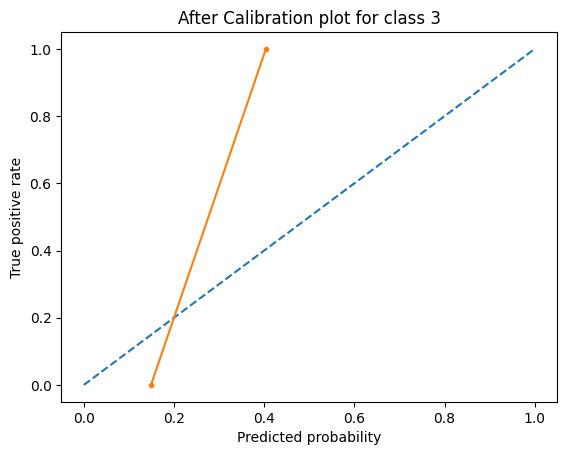

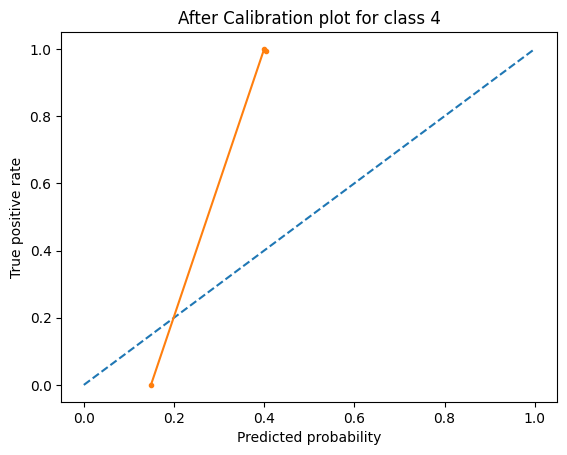

In [52]:
plot_calibration(models, test_dataset, threshold=threshold)